<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/ai_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [2]:
from google.colab import userdata

# Define project information
PROJECT_ID = userdata.get('PROJECT_ID')
LOCATION = userdata.get('LOCATION')


# create a new project
# https://console.cloud.google.com/vertex-ai/


# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [88]:
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image, Part

In [4]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

In [89]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

Image width: 1200
Image height: 800
-------Prompt--------


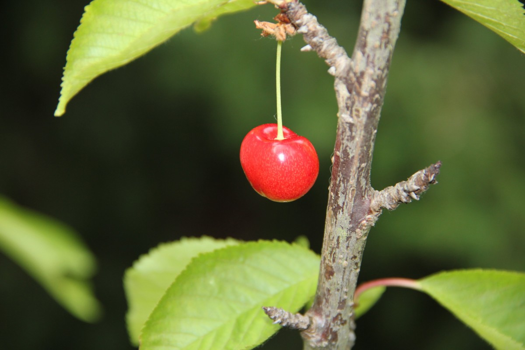

you have an image of a cherry on a tree, the image resolution is 1200*800, mark the nearest cherry in the photo and return the tuple of the coordinates without comments
(640.0, 400.0)


In [123]:
import re

filename = "cherry.jpg"

image = Image.load_from_file(filename)


# Assuming you have the image loaded into a variable named 'image'
pil_image = PIL_Image.open(filename)  # Replace 'image.jpg' with the actual image path

# Get the image width and height
width, height = pil_image.size

# Print the width and height
print(f"Image width: {width}")
print(f"Image height: {height}")


prompt = f"you have an image of a cherry on a tree, the image resolution is {width}*{height}, mark the nearest cherry in the photo and return the tuple of the coordinates without comments"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)


cherry_point = ''

for response in responses:
    cherry_point += response.text

def str_to_tuple(data_str):
  tuple_str = re.sub(r"[()]|\n", "", data_str).split(",")
  return tuple(float(num) for num in tuple_str)

tuple_data = str_to_tuple(cherry_point)
print(tuple_data)

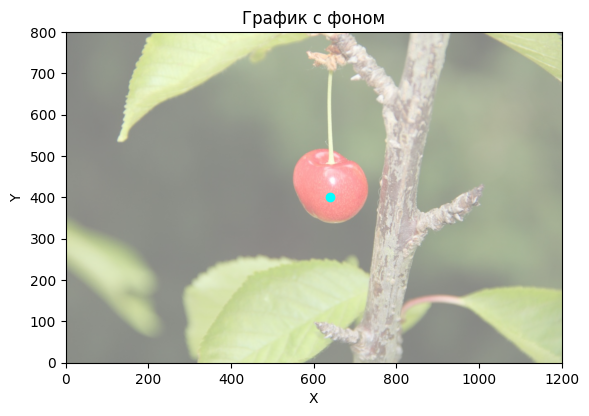

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Загружаем изображение
image = plt.imread(filename)

# Создаем фигуру и оси
fig, ax = plt.subplots()

# Отображаем данные на графике
ax.scatter(tuple_data[0], tuple_data[1], color='aqua')

# Добавляем фоновый рисунок
ax.imshow(image, extent=(0, width, 0, height), alpha=0.5)

# Настраиваем остальные элементы графика
ax.set_title('График с фоном')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Отображаем график
plt.show()
